# Cats vs Dogs Pipeline Testing Notebook

This notebook tests the main components of the Cats vs Dogs image pipeline: data acquisition, splitting, basic EDA, preprocessing, and PyTorch dataloaders.


## 1. Import Required Libraries
Import all necessary libraries for image classification, data handling, and visualization.

In [1]:
# 1. Imports
import os
import glob
import shutil
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split

import torch
from torchvision import transforms

# Ensure src/ is on path
import sys
sys.path.insert(0, '../src')

from data.download_data import download_cats_vs_dogs_data
from data.image_dataset import get_dataloaders


In [2]:
# 2. Data acquisition (run once per machine)

print("=" * 60)
print("STEP 1: DATA ACQUISITION")
print("=" * 60)

cache_path = download_cats_vs_dogs_data()
if cache_path:
    print("\nDataset downloaded to cache!")
else:
    print("\nDataset not found. Please check Kaggle credentials.")


STEP 1: DATA ACQUISITION


c:\Users\palee\miniconda3\envs\heart-disease-mlops\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset downloaded successfully!
Dataset path: C:\Users\palee\.cache\kagglehub\datasets\bhavikjikadara\dog-and-cat-classification-dataset\versions\1

Dataset downloaded to cache!


In [3]:
# 3. Copy dataset from cache to project data/raw/cats_vs_dogs (idempotent)

local_dataset_dir = '../data/raw/cats_vs_dogs'

if cache_path and not os.path.exists(local_dataset_dir):
    print(f"Copying dataset from cache to {local_dataset_dir}...")
    shutil.copytree(cache_path, local_dataset_dir)
    print("Copy complete!")
else:
    print(f"Dataset already available at: {local_dataset_dir}")


Dataset already available at: ../data/raw/cats_vs_dogs


In [4]:
# 4. Train/Val/Test split (run once after initial copy)

print("=" * 60)
print("STEP 2: TRAIN / VAL / TEST SPLIT")
print("=" * 60)

src_cat_dir = os.path.join(local_dataset_dir, 'PetImages', 'Cat')
src_dog_dir = os.path.join(local_dataset_dir, 'PetImages', 'Dog')

# Limit to 1000 per class for quick experimentation
cat_images = glob.glob(os.path.join(src_cat_dir, '*.jpg'))[:1000]
dog_images = glob.glob(os.path.join(src_dog_dir, '*.jpg'))[:1000]

def is_valid_image(path: str) -> bool:
    try:
        img = Image.open(path)
        img.verify()
        return True
    except Exception as e:
        print(f'Corrupted image skipped: {path} ({e})')
        return False

cat_images = [p for p in cat_images if is_valid_image(p)]
dog_images = [p for p in dog_images if is_valid_image(p)]

# 80 / 10 / 10 split
cat_train, cat_temp = train_test_split(cat_images, test_size=0.2, random_state=42)
cat_val,   cat_test = train_test_split(cat_temp, test_size=0.5, random_state=42)

dog_train, dog_temp = train_test_split(dog_images, test_size=0.2, random_state=42)
dog_val,   dog_test = train_test_split(dog_temp, test_size=0.5, random_state=42)

def copy_images(image_list, dest_dir):
    os.makedirs(dest_dir, exist_ok=True)
    for img_path in image_list:
        try:
            shutil.copy(img_path, dest_dir)
        except Exception as e:
            print(f'Failed to copy {img_path}: {e}')

base_dir = local_dataset_dir
splits = ['train', 'val', 'test']
for split in splits:
    for cls in ['cats', 'dogs']:
        os.makedirs(os.path.join(base_dir, split, cls), exist_ok=True)

copy_images(cat_train, os.path.join(base_dir, 'train', 'cats'))
copy_images(cat_val,   os.path.join(base_dir, 'val',   'cats'))
copy_images(cat_test,  os.path.join(base_dir, 'test',  'cats'))

copy_images(dog_train, os.path.join(base_dir, 'train', 'dogs'))
copy_images(dog_val,   os.path.join(base_dir, 'val',   'dogs'))
copy_images(dog_test,  os.path.join(base_dir, 'test',  'dogs'))

print("Train/Val/Test split complete! (subset only)")


STEP 2: TRAIN / VAL / TEST SPLIT
Train/Val/Test split complete! (subset only)


## 2. Load Sample Data
Load and visualize sample images from the Cats vs Dogs dataset.

STEP 3: SAMPLE VISUALIZATION


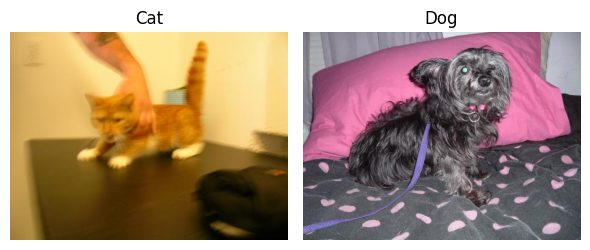

In [5]:
# 5. Load sample images (for sanity check)

print("=" * 60)
print("STEP 3: SAMPLE VISUALIZATION")
print("=" * 60)

train_dir = os.path.join(local_dataset_dir, 'train')

sample_cat = os.path.join(train_dir, 'cats',
                          os.listdir(os.path.join(train_dir, 'cats'))[0])
sample_dog = os.path.join(train_dir, 'dogs',
                          os.listdir(os.path.join(train_dir, 'dogs'))[0])

fig, axes = plt.subplots(1, 2, figsize=(6, 4))
axes[0].imshow(Image.open(sample_cat))
axes[0].set_title('Cat')
axes[0].axis('off')

axes[1].imshow(Image.open(sample_dog))
axes[1].set_title('Dog')
axes[1].axis('off')

plt.tight_layout()
plt.show()


## 3. Component 1: Data Preprocessing
Apply image resizing, normalization, and augmentations using PyTorch transforms.

STEP 4: PREPROCESSING & AUGMENTATION


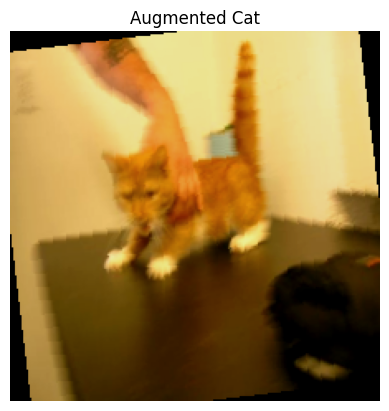

In [6]:
# 6. Data preprocessing & augmentation demo

print("=" * 60)
print("STEP 4: PREPROCESSING & AUGMENTATION")
print("=" * 60)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

img = Image.open(sample_cat)
aug_img = transform(img)

# Undo normalization just for display
unnorm = aug_img.clone()
for c, (mean, std) in enumerate(zip([0.485, 0.456, 0.406],
                                    [0.229, 0.224, 0.225])):
    unnorm[c] = unnorm[c] * std + mean
unnorm = torch.clamp(unnorm, 0.0, 1.0)

plt.imshow(np.transpose(unnorm.numpy(), (1, 2, 0)))
plt.title('Augmented Cat')
plt.axis('off')
plt.show()


## 4. Component 2: Feature Engineering
Analyze class distribution and prepare labels for binary classification.

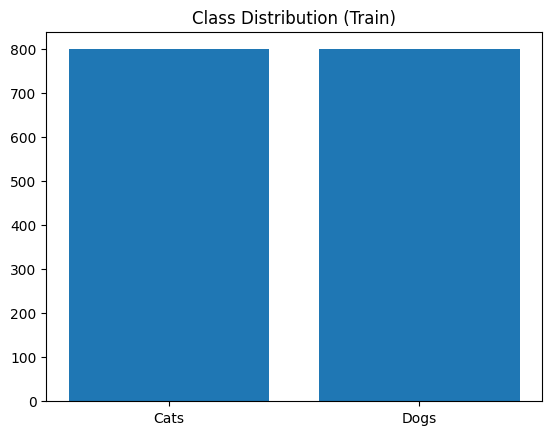

In [7]:
# 7. Class distribution (train split only)

cat_count = len(os.listdir(os.path.join(train_dir, 'cats')))
dog_count = len(os.listdir(os.path.join(train_dir, 'dogs')))

plt.bar(['Cats', 'Dogs'], [cat_count, dog_count])
plt.title('Class Distribution (Train)')
plt.show()


## 5. Component 3: Model Training
Train a simple CNN for binary classification (placeholder for model code).

In [8]:
# 8. Dataloaders wiring test

print("=" * 60)
print("STEP 5: DATALOADERS TEST")
print("=" * 60)

dataloaders = get_dataloaders(local_dataset_dir, batch_size=32)

for split in ['train', 'val', 'test']:
    ds = dataloaders[split].dataset
    print(f"{split}: {len(ds)} images, classes = {ds.classes}")

# Example batch
images, labels = next(iter(dataloaders['train']))
print(f"Train batch shape: {images.shape}, labels shape: {labels.shape}")


STEP 5: DATALOADERS TEST
train: 1600 images, classes = ['cats', 'dogs']
val: 200 images, classes = ['cats', 'dogs']
test: 200 images, classes = ['cats', 'dogs']
Train batch shape: torch.Size([32, 3, 224, 224]), labels shape: torch.Size([32])


## 6. Component 4: Model Evaluation
Evaluate the trained model using accuracy, loss curves, and confusion matrix.

In [ ]:
# Placeholder for model evaluation
# Evaluate accuracy, plot loss curves, and show confusion matrix here

## 7. Sequential Testing of Components
Test each component in sequence, verifying outputs and ensuring correctness at each stage.